# Attention & Context Length Analysis

**Goal**: Deep dive into attention mechanisms and context length configurations.

**Key Questions**:
1. How has context length evolved across the ecosystem?
2. What GQA ratios are most common?
3. What RoPE configurations are being used?
4. How do head dimensions vary?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Style matching main repo
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

In [2]:
df = pd.read_csv('../data/model_configs_expanded.csv', low_memory=False)

# Convert boolean columns
bool_cols = [c for c in df.columns if c.startswith('is_') or c.startswith('uses_')]
for col in bool_cols:
    df[col] = df[col].map({'True': True, 'False': False, True: True, False: False})

print(f"Total models: {len(df):,}")

Total models: 14,557


## 1. Context Length Deep Dive

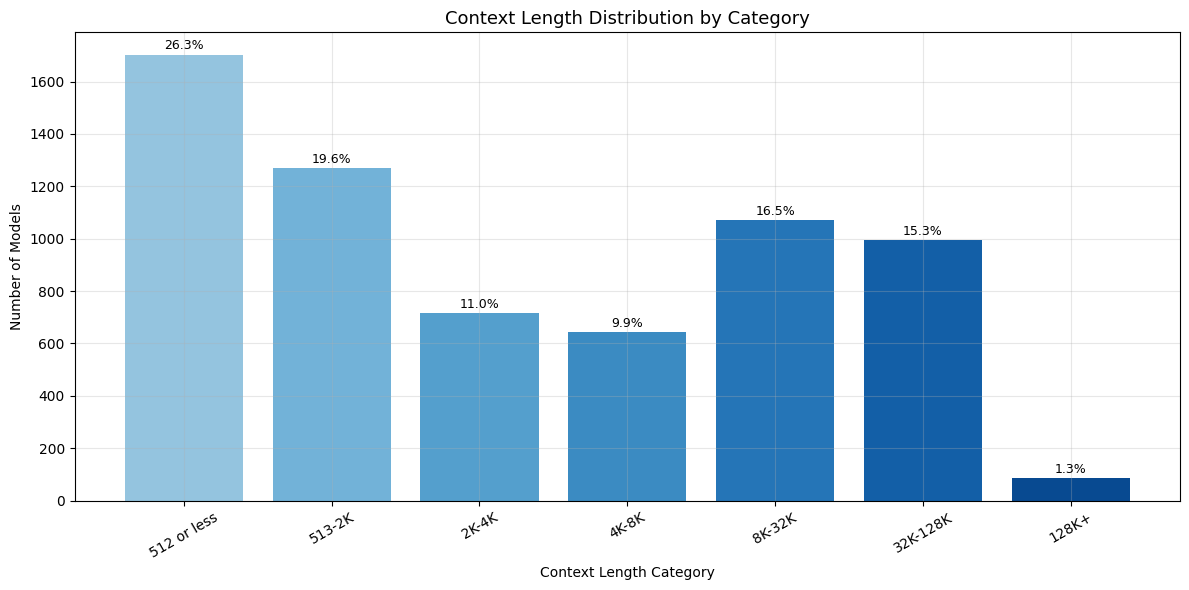


Context length statistics:
  Min: 40
  Max: 10,240,000
  Median: 4,096
  Mean: 37,538


In [3]:
# Convert to numeric first
context = pd.to_numeric(df['config_max_position_embeddings'], errors='coerce').dropna()

# Define context length categories
def categorize_context(x):
    if pd.isna(x):
        return 'unknown'
    x = float(x)
    if x <= 512:
        return '512 or less'
    elif x <= 2048:
        return '513-2K'
    elif x <= 4096:
        return '2K-4K'
    elif x <= 8192:
        return '4K-8K'
    elif x <= 32768:
        return '8K-32K'
    elif x <= 131072:
        return '32K-128K'
    else:
        return '128K+'

context_cats = context.apply(categorize_context)
cat_order = ['512 or less', '513-2K', '2K-4K', '4K-8K', '8K-32K', '32K-128K', '128K+']
context_cat_counts = context_cats.value_counts().reindex(cat_order).fillna(0).astype(int)

fig, ax = plt.subplots(figsize=(12, 6))

# Bar chart of categories
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(cat_order)))
bars = ax.bar(cat_order, context_cat_counts.values, color=colors)
ax.set_xlabel('Context Length Category')
ax.set_ylabel('Number of Models')
ax.set_title('Context Length Distribution by Category', fontsize=13)
ax.tick_params(axis='x', rotation=30)

# Add percentage labels
total = context_cat_counts.sum()
for bar, val in zip(bars, context_cat_counts.values):
    pct = val / total * 100
    ax.text(bar.get_x() + bar.get_width()/2, val + 20, 
                 f'{pct:.1f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('figures/context_length_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nContext length statistics:")
print(f"  Min: {context.min():,.0f}")
print(f"  Max: {context.max():,.0f}")
print(f"  Median: {context.median():,.0f}")
print(f"  Mean: {context.mean():,.0f}")

## 2. GQA (Grouped Query Attention) Analysis

In [4]:
# Filter to models with GQA
df_gqa = df[df['uses_gqa'] == True].copy()
gqa_count = len(df_gqa)
non_gqa_count = len(df) - gqa_count

print(f"Models with GQA: {gqa_count:,} ({gqa_count/len(df)*100:.1f}%)")
print(f"Models without GQA: {non_gqa_count:,} ({non_gqa_count/len(df)*100:.1f}%)")

Models with GQA: 1,976 (13.6%)
Models without GQA: 12,581 (86.4%)


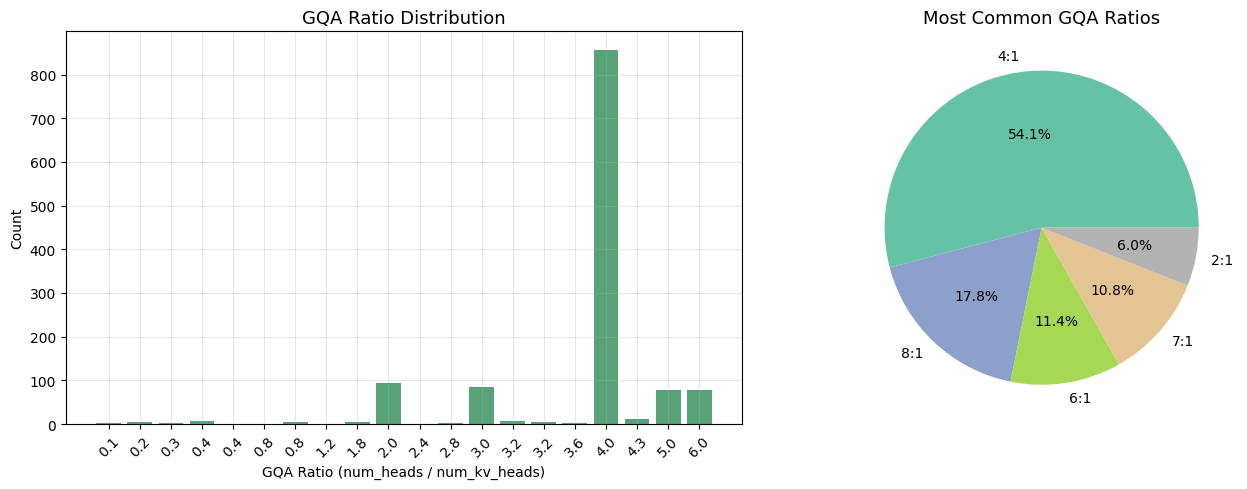


Most common GQA ratios:
  4.0:1 → 856 models (43.7%)
  8.0:1 → 281 models (14.3%)
  6.4:1 → 180 models (9.2%)
  7.0:1 → 171 models (8.7%)
  2.0:1 → 95 models (4.8%)
  3.0:1 → 84 models (4.3%)
  5.0:1 → 78 models (4.0%)
  6.0:1 → 78 models (4.0%)
  64.4:1 → 35 models (1.8%)
  12.6:1 → 13 models (0.7%)


In [5]:
# GQA Ratio analysis
gqa_ratio = pd.to_numeric(df_gqa['config_gqa_ratio'], errors='coerce').dropna()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of GQA ratios
ratio_counts = gqa_ratio.value_counts().sort_index().head(20)
axes[0].bar(range(len(ratio_counts)), ratio_counts.values, color='seagreen', alpha=0.8)
axes[0].set_xticks(range(len(ratio_counts)))
axes[0].set_xticklabels([f'{float(r):.1f}' for r in ratio_counts.index], rotation=45)
axes[0].set_xlabel('GQA Ratio (num_heads / num_kv_heads)')
axes[0].set_ylabel('Count')
axes[0].set_title('GQA Ratio Distribution', fontsize=13)

# Common ratios as pie chart
common_ratios = gqa_ratio.value_counts().head(5)
colors_pie = plt.cm.Set2(np.linspace(0, 1, len(common_ratios)))
axes[1].pie(common_ratios.values, labels=[f'{float(r):.0f}:1' for r in common_ratios.index],
            autopct='%1.1f%%', colors=colors_pie)
axes[1].set_title('Most Common GQA Ratios', fontsize=13)

plt.tight_layout()
plt.savefig('figures/gqa_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nMost common GQA ratios:")
for ratio, count in gqa_ratio.value_counts().head(10).items():
    pct = count / len(gqa_ratio) * 100
    print(f"  {float(ratio):.1f}:1 → {count:,} models ({pct:.1f}%)")

## 3. RoPE (Rotary Position Embedding) Analysis

In [6]:
# RoPE adoption
rope_count = (df['uses_rope'] == True).sum()
print(f"Models using RoPE: {rope_count:,} ({rope_count/len(df)*100:.1f}%)")

Models using RoPE: 2,402 (16.5%)


TypeError: '>=' not supported between instances of 'str' and 'float'

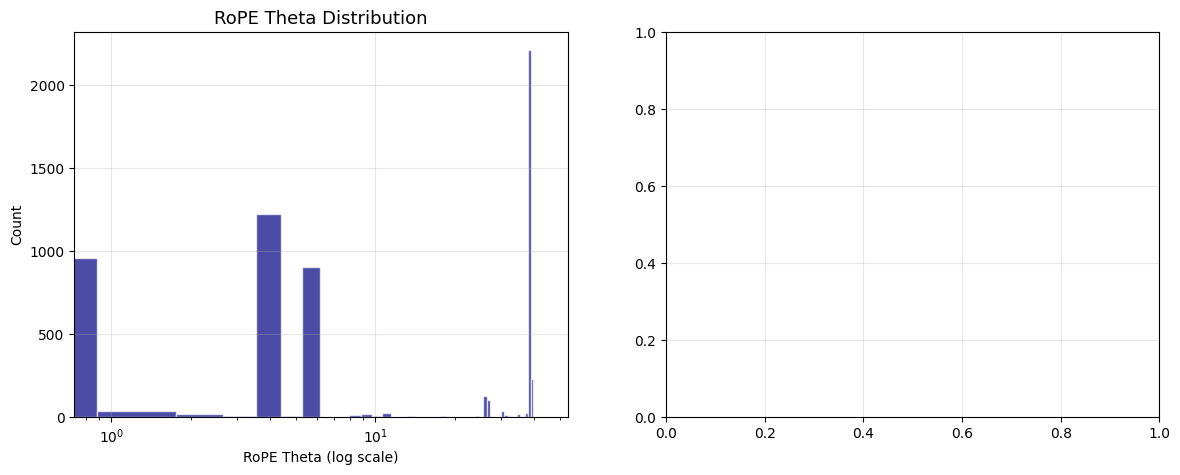

In [7]:
# RoPE Theta analysis
rope_theta = df['config_rope_theta'].dropna()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Log-scale histogram
axes[0].hist(rope_theta, bins=50, color='navy', alpha=0.7, edgecolor='white')
axes[0].set_xscale('log')
axes[0].set_xlabel('RoPE Theta (log scale)')
axes[0].set_ylabel('Count')
axes[0].set_title('RoPE Theta Distribution', fontsize=13)

# Most common theta values
theta_counts = rope_theta.value_counts().head(10)
labels = [f'{t:.0e}' if t >= 1e6 else f'{t:.0f}' for t in theta_counts.index]
axes[1].barh(range(len(theta_counts)), theta_counts.values, color='navy', alpha=0.8)
axes[1].set_yticks(range(len(theta_counts)))
axes[1].set_yticklabels(labels)
axes[1].invert_yaxis()
axes[1].set_xlabel('Count')
axes[1].set_title('Most Common RoPE Theta Values', fontsize=13)

plt.tight_layout()
plt.savefig('figures/rope_theta_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nMost common RoPE theta values:")
for theta, count in theta_counts.items():
    print(f"  {theta:,.0f} → {count:,} models")

In [ ]:
# RoPE Scaling Types
rope_scaling = df['config_rope_scaling_type'].dropna()

if len(rope_scaling) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    scaling_counts = rope_scaling.value_counts()
    ax.barh(range(len(scaling_counts)), scaling_counts.values, color='darkblue', alpha=0.8)
    ax.set_yticks(range(len(scaling_counts)))
    ax.set_yticklabels(scaling_counts.index)
    ax.invert_yaxis()
    ax.set_xlabel('Count')
    ax.set_title('RoPE Scaling Types', fontsize=13)
    
    plt.tight_layout()
    plt.savefig('figures/rope_scaling_types.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nRoPE scaling type distribution:")
    print(scaling_counts)

## 4. Head Dimension Analysis

In [ ]:
# Head dimension = hidden_size / num_attention_heads
head_dim = df['config_head_dimension'].dropna()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution
dim_counts = head_dim.value_counts().sort_index()
# Focus on common values
dim_common = dim_counts[dim_counts >= 5]
axes[0].bar(dim_common.index.astype(int), dim_common.values, color='darkorange', alpha=0.8)
axes[0].set_xlabel('Head Dimension')
axes[0].set_ylabel('Count')
axes[0].set_title('Head Dimension Distribution', fontsize=13)

# Top head dimensions
top_dims = head_dim.value_counts().head(10)
axes[1].pie(top_dims.values, labels=[f'{int(d)}' for d in top_dims.index],
            autopct='%1.1f%%', colors=sns.color_palette('Oranges', len(top_dims)))
axes[1].set_title('Most Common Head Dimensions', fontsize=13)

plt.tight_layout()
plt.savefig('figures/head_dimension_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nMost common head dimensions:")
for dim, count in top_dims.items():
    pct = count / len(head_dim) * 100
    print(f"  {int(dim)} → {count:,} models ({pct:.1f}%)")

## 5. Attention Heads vs Hidden Size Relationship

In [ ]:
# Scatter plot of hidden size vs num attention heads
df_attn = df[['config_hidden_size', 'config_num_attention_heads', 'config_head_dimension']].dropna()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Hidden size vs Num heads (colored by head dim)
scatter = axes[0].scatter(df_attn['config_num_attention_heads'], df_attn['config_hidden_size'],
                          c=df_attn['config_head_dimension'], cmap='viridis', alpha=0.5, s=20)
axes[0].set_xlabel('Number of Attention Heads')
axes[0].set_ylabel('Hidden Size')
axes[0].set_title('Hidden Size vs Attention Heads', fontsize=13)
plt.colorbar(scatter, ax=axes[0], label='Head Dim')

# Add reference lines for common head dimensions
x_range = np.array([4, 128])
for hd, color in [(64, 'red'), (128, 'blue')]:
    axes[0].plot(x_range, x_range * hd, '--', color=color, alpha=0.5, label=f'head_dim={hd}')
axes[0].legend()

# Head dim vs hidden size
axes[1].scatter(df_attn['config_hidden_size'], df_attn['config_head_dimension'],
                alpha=0.3, s=20, color='teal')
axes[1].set_xlabel('Hidden Size')
axes[1].set_ylabel('Head Dimension')
axes[1].set_title('Head Dimension vs Hidden Size', fontsize=13)

plt.tight_layout()
plt.savefig('figures/attention_relationships.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Context Per Layer Analysis

In [ ]:
# Context per layer = max_position_embeddings / num_hidden_layers
ctx_per_layer = df['config_context_per_layer'].dropna()

fig, ax = plt.subplots(figsize=(12, 5))

ax.hist(ctx_per_layer, bins=50, color='mediumpurple', alpha=0.7, edgecolor='white')
ax.axvline(ctx_per_layer.median(), color='red', linestyle='--', linewidth=2, 
           label=f'Median: {ctx_per_layer.median():.0f}')
ax.set_xscale('log')
ax.set_xlabel('Context Per Layer (log scale)')
ax.set_ylabel('Count')
ax.set_title('Context Length Per Layer Distribution', fontsize=13)
ax.legend()

plt.tight_layout()
plt.savefig('figures/context_per_layer.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nContext per layer statistics:")
print(f"  Min: {ctx_per_layer.min():.1f}")
print(f"  Max: {ctx_per_layer.max():.1f}")
print(f"  Median: {ctx_per_layer.median():.1f}")
print(f"  Mean: {ctx_per_layer.mean():.1f}")

## 7. Summary Dashboard

In [ ]:
print("="*80)
print("ATTENTION & CONTEXT ANALYSIS SUMMARY")
print("="*80)

print(f"\n📏 CONTEXT LENGTH")
print(f"   Median context: {context.median():,.0f}")
print(f"   Range: [{context.min():,.0f}, {context.max():,.0f}]")
print(f"   Models with 128K+ context: {(context >= 131072).sum():,}")

print(f"\n🔄 GQA (Grouped Query Attention)")
print(f"   Adoption rate: {gqa_count/len(df)*100:.1f}%")
print(f"   Most common ratio: {gqa_ratio.mode().iloc[0] if len(gqa_ratio) > 0 else 'N/A'}:1")

print(f"\n🔀 RoPE (Rotary Position Embedding)")
print(f"   Adoption rate: {rope_count/len(df)*100:.1f}%")
print(f"   Most common theta: {rope_theta.mode().iloc[0]:,.0f}" if len(rope_theta) > 0 else "N/A")

print(f"\n🎯 HEAD DIMENSION")
print(f"   Most common: {int(head_dim.mode().iloc[0])}")
print(f"   Median: {head_dim.median():.0f}")